### use Full_Exp23_Paper_2_mesh to run a simple test to see T effect on lithium plating

In [3]:
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl; 
fs=17; font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)




In [5]:

import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(
    os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 


In [6]:
########################     Global settings!!!
rows_per_file = 3;  Scan_end_end = 24;
purpose_i = "Full_Exp23_Paper_2_mesh"

On_HPC = False 
Runshort  =   False                    # a long run or a quick test

# import all functions 
from Fun_P2 import * 

if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 4; # manually specify

def Get_Para_dict_list_i(i_bundle,index):
    Scan_start = (i_bundle-1)*rows_per_file+1;    
    Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
    purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
    # interpetation: Simnon suggested, with cracking activation, heat transfer
    para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters

    if On_HPC:                          # Run on HPC
        Path_csv = f"InputData/{purpose_i}/" 
        Path_NiallDMA = "InputData/" 
        BasicPath=os.getcwd() 
        Para_file = Path_csv +  para_csv
    else:
        import sys  
        str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
        str_path_1 = os.path.abspath(
            os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
        sys.path.append(str_path_1) 
        Path_NiallDMA = os.path.expanduser(
            "~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
        BasicPath =  os.path.expanduser(
            "~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
        Para_file = BasicPath+f'/Get_Random_sets/{purpose_i}/'+para_csv
        
    if not os.path.exists(BasicPath +"/"+ purpose):
        os.mkdir(BasicPath +"/"+ purpose);


    # Load the random file
    parameter_names, combinations = load_combinations_from_csv(Para_file)


    pool_no = len(combinations)
    Indexs  = np.arange(Scan_start-1,Scan_end)
    index_list = Indexs+1
    """ para_dict_Same = {
    "Total ageing cycles":int(tot_cyc), # 
    "Ageing cycles between RPT":int(cyc_age), # 
    "Update cycles for ageing": int(cyc_age),
    } """
    # Get all para
    Para_dict_list = []
    # get all dictionaries
    for combination in combinations:
        input_dict = {}
        for parameter_name,para_value in zip(parameter_names,combination ):
            input_dict[parameter_name] = para_value
        Para_dict_list.append(input_dict)
    print(f"Total scan case is {len(Para_dict_list)}")
    return Para_dict_list[index],purpose,pool_no,index_list,BasicPath,Path_NiallDMA

Para_dict_list_i10,purpose,pool_no,index_list,BasicPath,Path_NiallDMA  = Get_Para_dict_list_i(1,2)
Para_dict_list_i25,purpose,pool_no,index_list,BasicPath,Path_NiallDMA  = Get_Para_dict_list_i(3,1)
Para_dict_list_i40,purpose,pool_no,index_list,BasicPath,Path_NiallDMA  = Get_Para_dict_list_i(4,2)

Total scan case is 3
Total scan case is 3
Total scan case is 3


In [7]:
Para_dict_list_3Ts = [
    Para_dict_list_i10,Para_dict_list_i25,
    Para_dict_list_i40]
for i in range(3):
    print(Para_dict_list_3Ts[i]['Ageing temperature'])
    print(Para_dict_list_3Ts[i]['Mesh list'])


10.0
[5,5,5,100,50]
25.0
[10,10,10,100,50]
40.0
[10,10,10,100,50]


In [8]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]
# Update 23-06-17 
#   para="Total heat transfer coefficient [W.m-2.K-1]";
#   output="Volume-averaged cell temperature [C]"
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


In [9]:
# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list_i10.keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %",
    "Error Res %","Error ageT %","Punish",
    "Dry out",]

head_pos = [ 
    "Total ageing cycles","Ageing cycles between RPT",
    "Update cycles for ageing",
    "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)   
Exp_pack = [
    Exp_All_Cell,Temp_Cell_Exp_All,
    Exp_Path,Exp_head,Exp_Temp_Cell,
    book_name_xlsx,]  
# remaining set-up for experiment and create folders

if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");
# scan:
fs = 13; dpi = 100;
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=False;  
Return_Sol=True;   Check_Small_Time=True;

Successfully create a excel file


In [10]:
(Para_dict_list_i10['Ageing temperature'])

10.0

In [11]:

if __name__ == "__main__":
    pool = multiprocessing.Pool(int(pool_no))
    processes = [
    pool.apply_async(
        Run_P2_Excel, 
        args=(
            Para_dict_i,BasicPath, Path_NiallDMA, 
            purpose,    Exp_pack, keys_all,dpi,fs,
            Runshort,   Plot_Exp,Timeout,Return_Sol,
            Check_Small_Time
        ) )
        for Para_dict_i in Para_dict_list_3Ts]
    Result = [p.get() for p in processes]

Start Now! Scan 3.Start Now! Scan 8.Start Now! Scan 12.


Read Exp-2 - Cell A RPT 0Read Exp-2 - Cell A RPT 0Read Exp-2 - Cell A RPT 0


Read Exp-2 - Cell A RPT 1Read Exp-2 - Cell A RPT 1

Read Exp-2 - Cell A RPT 1
Read Exp-2 - Cell A RPT 2
Read Exp-2 - Cell A RPT 2Read Exp-2 - Cell A RPT 2

Read Exp-2 - Cell A RPT 3
Read Exp-2 - Cell A RPT 3Read Exp-2 - Cell A RPT 3

Read Exp-2 - Cell A RPT 4Read Exp-2 - Cell A RPT 4

Read Exp-2 - Cell A RPT 4
Read Exp-2 - Cell A RPT 5
Read Exp-2 - Cell A RPT 5
Read Exp-2 - Cell A RPT 5
Read Exp-2 - Cell A RPT 6Read Exp-2 - Cell A RPT 6

Read Exp-2 - Cell A RPT 6
Read Exp-2 - Cell A RPT 7
Read Exp-2 - Cell A RPT 7Read Exp-2 - Cell A RPT 7

Read Exp-2 - Cell A RPT 8Read Exp-2 - Cell A RPT 8

Read Exp-2 - Cell A RPT 8
Read Exp-2 - Cell A RPT 9Read Exp-2 - Cell A RPT 9

Read Exp-2 - Cell A RPT 9
Read Exp-2 - Cell A RPT 10Read Exp-2 - Cell A RPT 10

Read Exp-2 - Cell A RPT 10


Read Exp-2 - Cell A RPT 11
Read Exp-2 - Cell A RPT 11Read Exp-2 - Cell A RPT 11

Read Exp-2 - Cell A RPT 12Read Exp-2 - Cell A RPT 12
Exp-2 - Cell A doesn't have RPT 13

Read Exp-2 - Cell A RPT 12Exp-2 - Cell A doesn't have RPT 14Exp-2 - Cell A doesn't have RPT 13


Exp-2 - Cell A doesn't have RPT 13Exp-2 - Cell A doesn't have RPT 14Exp-2 - Cell A doesn't have RPT 15

Exp-2 - Cell A doesn't have RPT 14
Exp-2 - Cell A doesn't have RPT 15
Exp-2 - Cell A doesn't have RPT 15

Read Exp-2 - Cell B RPT 0
Read Exp-2 - Cell B RPT 0
Read Exp-2 - Cell B RPT 0
Read Exp-2 - Cell B RPT 1Read Exp-2 - Cell B RPT 1

Read Exp-2 - Cell B RPT 1
Read Exp-2 - Cell B RPT 2
Read Exp-2 - Cell B RPT 2
Read Exp-2 - Cell B RPT 2
Read Exp-2 - Cell B RPT 3
Read Exp-2 - Cell B RPT 3
Read Exp-2 - Cell B RPT 3
Read Exp-2 - Cell B RPT 4
Read Exp-2 - Cell B RPT 4Read Exp-2 - Cell B RPT 4

Read Exp-2 - Cell B RPT 5
Read Exp-2 - Cell B RPT 5Read Exp-2 - Cell B RPT 5

Read Exp-2 - Cell B RPT 6Read Exp-2 - Cell B RPT 6

Rea

At t = 338.953 and h = 7.06019e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.516 RPT cycles within 2 minutes, 9 seconds
Scan 3: Finish post-process for No.516 RPT cycles within 1.121 s
Scan 12: Finish for No.0 ageing cycles within 58 minutes, 9 seconds
Scan 12: Finish post-process for No.516 ageing cycles within 187.667 ms
Scan 12: Finish for No.516 RPT cycles within 6 minutes, 37 seconds
Scan 12: Finish post-process for No.516 RPT cycles within 1.940 s
Scan 8: Finish for No.0 ageing cycles within 1 hour, 14 minutes, 25 seconds
Scan 8: Finish post-process for No.516 ageing cycles within 196.581 ms
Scan 8: Finish for No.516 RPT cycles within 6 minutes, 31 seconds
Scan 8: Finish post-process for No.516 RPT cycles within 2.033 s
Scan 3: Finish for No.516 ageing cycles within 43 minutes, 45 seconds
Scan 3: Finish post-process for No.1032 ageing cycles within 85.587 ms


At t = 482.683 and h = 4.41131e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 248.02 and h = 8.17571e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 248.019 and h = 3.11871e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.0188 and h = 3.17173e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.1032 RPT cycles within 2 minutes, 25 seconds
Scan 3: Finish post-process for No.1032 RPT cycles within 1.123 s
Scan 12: Finish for No.516 ageing cycles within 1 hour, 1 minute, 43 seconds
Scan 12: Finish post-process for No.1032 ageing cycles within 139.983 ms
Scan 3: Finish for No.1032 ageing cycles within 43 minutes, 13 seconds
Scan 3: Finish post-process for No.1548 ageing cycles within 89.709 ms


At t = 160.562 and h = 2.69971e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 160.564 and h = 2.19999e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 310.923 and h = 7.33519e-13, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.1548 RPT cycles within 2 minutes, 18 seconds
Scan 3: Finish post-process for No.1548 RPT cycles within 1.239 s
Scan 12: Finish for No.1032 RPT cycles within 6 minutes, 39 seconds
Scan 12: Finish post-process for No.1032 RPT cycles within 1.949 s
Scan 8: Finish for No.516 ageing cycles within 1 hour, 16 minutes, 38 seconds
Scan 8: Finish post-process for No.1032 ageing cycles within 138.458 ms


At t = 311.667 and h = 2.41003e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 8: Finish for No.1032 RPT cycles within 6 minutes, 40 seconds
Scan 8: Finish post-process for No.1032 RPT cycles within 1.841 s
Scan 3: Finish for No.1548 ageing cycles within 42 minutes, 36 seconds
Scan 3: Finish post-process for No.2064 ageing cycles within 82.775 ms
Scan 3: Finish for No.2064 RPT cycles within 2 minutes, 12 seconds
Scan 3: Finish post-process for No.2064 RPT cycles within 1.284 s
Scan 12: Finish for No.1032 ageing cycles within 1 hour, 4 minutes, 8 seconds
Scan 12: Finish post-process for No.1548 ageing cycles within 101.513 ms


At t = 527.442 and h = 8.57777e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 253.437 and h = 1.49029e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 253.436 and h = 9.35785e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.436 and h = 2.30594e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 12: Finish for No.1548 RPT cycles within 7 minutes, 7 seconds
Scan 12: Finish post-process for No.1548 RPT cycles within 1.937 s
Scan 3: Finish for No.2064 ageing cycles within 43 minutes, 23 seconds
Scan 3: Finish post-process for No.2580 ageing cycles within 104.931 ms


At t = 353.142 and h = 1.67995e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.2580 RPT cycles within 2 minutes, 12 seconds
Scan 3: Finish post-process for No.2580 RPT cycles within 1.241 s
Scan 8: Finish for No.1032 ageing cycles within 1 hour, 17 minutes, 35 seconds
Scan 8: Finish post-process for No.1548 ageing cycles within 113.794 ms


At t = 527.748 and h = 8.85875e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 254.408 and h = 4.45422e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 254.408 and h = 2.11963e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 104.408 and h = 8.19148e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 8: Finish for No.1548 RPT cycles within 7 minutes, 2 seconds
Scan 8: Finish post-process for No.1548 RPT cycles within 1.799 s
Scan 3: Finish for No.2580 ageing cycles within 44 minutes, 3 seconds
Scan 3: Finish post-process for No.3096 ageing cycles within 89.240 ms


At t = 273.279 and h = 1.86737e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 273.279 and h = 1.58374e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.279 and h = 1.5264e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.3096 RPT cycles within 2 minutes, 21 seconds
Scan 3: Finish post-process for No.3096 RPT cycles within 989.113 ms
Scan 12: Finish for No.1548 ageing cycles within 1 hour, 4 minutes, 2 seconds
Scan 12: Finish post-process for No.2064 ageing cycles within 97.461 ms


At t = 198.683 and h = 3.12638e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 198.679 and h = 1.06134e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 12: Finish for No.2064 RPT cycles within 6 minutes, 18 seconds
Scan 12: Finish post-process for No.2064 RPT cycles within 1.850 s
Scan 3: Finish for No.3096 ageing cycles within 45 minutes, 27 seconds
Scan 3: Finish post-process for No.3612 ageing cycles within 93.394 ms


At t = 195.748 and h = 1.95988e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 195.748 and h = 3.05613e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.3612 RPT cycles within 2 minutes, 14 seconds
Scan 3: Finish post-process for No.3612 RPT cycles within 1.118 s
Scan 8: Finish for No.1548 ageing cycles within 1 hour, 17 minutes, 1 second
Scan 8: Finish post-process for No.2064 ageing cycles within 107.910 ms


At t = 199.592 and h = 9.3295e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.59 and h = 3.55702e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 8: Finish for No.2064 RPT cycles within 6 minutes, 18 seconds
Scan 8: Finish post-process for No.2064 RPT cycles within 1.888 s
Scan 12: Finish for No.2064 ageing cycles within 1 hour, 5 minutes, 4 seconds
Scan 12: Finish post-process for No.2580 ageing cycles within 114.866 ms


At t = 524.575 and h = 6.92385e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 146.348 and h = 1.32888e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 146.348 and h = 1.26911e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 146.348 and h = 1.85099e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 12: Finish for No.2580 RPT cycles within 6 minutes, 28 seconds
Scan 12: Finish post-process for No.2580 RPT cycles within 1.864 s
Scan 3: Finish for No.3612 ageing cycles within 44 minutes, 32 seconds
Scan 3: Finish post-process for No.4128 ageing cycles within 81.192 ms


At t = 119.745 and h = 1.71189e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 119.747 and h = 9.94806e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 119.747 and h = 4.08276e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.4128 RPT cycles within 2 minutes, 21 seconds
Scan 3: Finish post-process for No.4128 RPT cycles within 1.239 s
Scan 3: Finish for No.4128 ageing cycles within 44 minutes, 18 seconds
Scan 3: Finish post-process for No.4644 ageing cycles within 100.011 ms
Scan 12: Finish for No.2580 ageing cycles within 1 hour, 1 minute, 55 seconds
Scan 12: Finish post-process for No.3096 ageing cycles within 141.892 ms
Scan 3: Finish for No.4644 RPT cycles within 2 minutes, 8 seconds
Scan 3: Finish post-process for No.4644 RPT cycles within 1.217 s
Scan 8: Finish for No.2064 ageing cycles within 1 hour, 18 minutes, 41 seconds
Scan 8: Finish post-process for No.2580 ageing cycles within 106.846 ms


At t = 96.1715 and h = 2.03822e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.1713 and h = 1.86573e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.1714 and h = 1.69424e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 521.88 and h = 6.17952e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 12: Finish for No.3096 RPT cycles within 6 minutes, 32 seconds
Scan 12: Finish post-process for No.3096 RPT cycles within 1.943 s


At t = 146.976 and h = 1.48142e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 146.976 and h = 8.75032e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 146.976 and h = 9.44194e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 8: Finish for No.2580 RPT cycles within 6 minutes, 38 seconds
Scan 8: Finish post-process for No.2580 RPT cycles within 1.911 s
Scan 3: Finish for No.4644 ageing cycles within 43 minutes, 45 seconds
Scan 3: Finish post-process for No.5160 ageing cycles within 115.900 ms


At t = 488.658 and h = 6.06867e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 331.753 and h = 2.33412e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.5160 RPT cycles within 2 minutes, 20 seconds
Scan 3: Finish post-process for No.5160 RPT cycles within 1.237 s
Scan 12: Finish for No.3096 ageing cycles within 1 hour, 4 minutes, 3 seconds
Scan 12: Finish post-process for No.3612 ageing cycles within 113.226 ms
Scan 12: Finish for No.3612 RPT cycles within 6 minutes, 13 seconds
Scan 12: Finish post-process for No.3612 RPT cycles within 1.860 s
Scan 8: Finish for No.2580 ageing cycles within 1 hour, 19 minutes, 54 seconds
Scan 8: Finish post-process for No.3096 ageing cycles within 108.047 ms
Scan 3: Finish for No.5160 ageing cycles within 44 minutes, 26 seconds
Scan 3: Finish post-process for No.5676 ageing cycles within 82.885 ms


At t = 259.82 and h = 1.0469e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 259.822 and h = 8.29811e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 109.82 and h = 4.92778e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.3523 and h = 1.59446e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.3523 and h = 2.73964e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.5676 RPT cycles within 2 minutes, 17 seconds
Scan 3: Finish post-process for No.5676 RPT cycles within 1.010 s


At t = 96.3523 and h = 1.71219e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 8: Finish for No.3096 RPT cycles within 6 minutes, 32 seconds
Scan 8: Finish post-process for No.3096 RPT cycles within 1.932 s
Scan 3: Finish for No.5676 ageing cycles within 43 minutes, 18 seconds
Scan 3: Finish post-process for No.6192 ageing cycles within 83.852 ms


At t = 189.437 and h = 5.48748e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 189.44 and h = 1.45467e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.6192 RPT cycles within 2 minutes, 11 seconds
Scan 3: Finish post-process for No.6192 RPT cycles within 1.028 s
Scan 3: Getting extra variables within 104.500 us
Scan 3: Finish all plots within 7.594 s
Successfully create a excel file
Scan 3: Successfully save json file!
Scan 3: Successfully save mat file!
Scan 3: Try saving within 34.531 ms
Succeed doing something in 9 hours, 14 minutes, 34 seconds
This is the end of No. 3  scan
Scan 12: Finish for No.3612 ageing cycles within 1 hour, 5 minutes, 6 seconds

Scan 12: Finish post-process for No.4128 ageing cycles within 97.658 msScan 12: Finish for No.4128 RPT cycles within 5 minutes, 42 seconds
Scan 12: Finish post-process for No.4128 RPT cycles within 1.577 s
Scan 8: Finish for No.3096 ageing cycles within 1 hour, 17 minutes, 24 seconds
Scan 8: Finish post-process for No.3612 ageing cycles within 110.187 ms
Scan 8: Finish for No.3612 RPT cycles within 5 minutes, 40 seconds
Scan 8: Finish post-process for No.3612 RP

At t = 316.636 and h = 3.948e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 12: Finish for No.4644 RPT cycles within 5 minutes, 53 seconds
Scan 12: Finish post-process for No.4644 RPT cycles within 1.720 s
Scan 8: Finish for No.3612 ageing cycles within 1 hour, 14 minutes, 35 seconds
Scan 8: Finish post-process for No.4128 ageing cycles within 118.138 ms
Scan 8: Finish for No.4128 RPT cycles within 5 minutes, 46 seconds
Scan 8: Finish post-process for No.4128 RPT cycles within 1.630 s
Scan 12: Finish for No.4644 ageing cycles within 56 minutes, 7 seconds
Scan 12: Finish post-process for No.5160 ageing cycles within 94.777 ms


At t = 273.273 and h = 1.87907e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 273.273 and h = 1.08275e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 123.272 and h = 6.76807e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 12: Finish for No.5160 RPT cycles within 5 minutes, 56 seconds
Scan 12: Finish post-process for No.5160 RPT cycles within 1.807 s
Scan 12: Finish for No.5160 ageing cycles within 55 minutes, 59 seconds
Scan 12: Finish post-process for No.5676 ageing cycles within 113.633 ms


At t = 231.276 and h = 2.03382e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 231.276 and h = 3.60527e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 8: Finish for No.4128 ageing cycles within 1 hour, 14 minutes, 39 seconds
Scan 8: Finish post-process for No.4644 ageing cycles within 126.392 ms
Scan 12: Finish for No.5676 RPT cycles within 5 minutes, 51 seconds
Scan 12: Finish post-process for No.5676 RPT cycles within 1.599 s


At t = 314.785 and h = 1.12096e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 8: Finish for No.4644 RPT cycles within 6 minutes, 6 seconds
Scan 8: Finish post-process for No.4644 RPT cycles within 1.842 s
Scan 12: Finish for No.5676 ageing cycles within 59 minutes, 49 seconds
Scan 12: Finish post-process for No.6192 ageing cycles within 102.879 ms


At t = 190.544 and h = 5.8434e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 190.545 and h = 1.63554e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 12: Finish for No.6192 RPT cycles within 5 minutes, 45 seconds
Scan 12: Finish post-process for No.6192 RPT cycles within 1.756 s
Scan 12: Getting extra variables within 193.600 us
Scan 12: Finish all plots within 6.727 s
Successfully create a excel file
Scan 12: Successfully save json file!
Scan 12: Successfully save mat file!
Scan 12: Try saving within 32.951 ms
Succeed doing something in 13 hours, 36 minutes, 47 seconds
This is the end of No. 12  scan
Scan 8: Finish for No.4644 ageing cycles within 1 hour, 15 minutes, 56 seconds
Scan 8: Finish post-process for No.5160 ageing cycles within 185.504 ms


At t = 270.586 and h = 1.83674e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 270.587 and h = 9.28855e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 120.586 and h = 3.16116e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 8: Finish for No.5160 RPT cycles within 6 minutes, 3 seconds
Scan 8: Finish post-process for No.5160 RPT cycles within 1.576 s
Scan 8: Finish for No.5160 ageing cycles within 1 hour, 10 minutes, 11 seconds
Scan 8: Finish post-process for No.5676 ageing cycles within 96.534 ms


At t = 227.702 and h = 3.05531e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 227.702 and h = 1.27677e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 8: Finish for No.5676 RPT cycles within 5 minutes, 14 seconds
Scan 8: Finish post-process for No.5676 RPT cycles within 1.587 s
Scan 8: Finish for No.5676 ageing cycles within 1 hour, 10 minutes, 38 seconds
Scan 8: Finish post-process for No.6192 ageing cycles within 96.103 ms


At t = 510.062 and h = 2.20029e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 186.037 and h = 2.5707e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 186.034 and h = 1.87115e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 8: Finish for No.6192 RPT cycles within 5 minutes, 11 seconds
Scan 8: Finish post-process for No.6192 RPT cycles within 1.526 s
Scan 8: Getting extra variables within 199.700 us
Scan 8: Finish all plots within 6.368 s
Successfully create a excel file
Scan 8: Successfully save json file!
Scan 8: Successfully save mat file!
Scan 8: Try saving within 38.263 ms
Succeed doing something in 16 hours, 29 minutes, 21 seconds
This is the end of No. 8  scan


In [ ]:
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
for result in Result:
    midc_merge_all.append(result[0])
    Sol_RPT_all.append(result[1])
    Sol_AGE_all.append(result[2]) 

In [ ]:
Sol_AGE_all[1]

[]

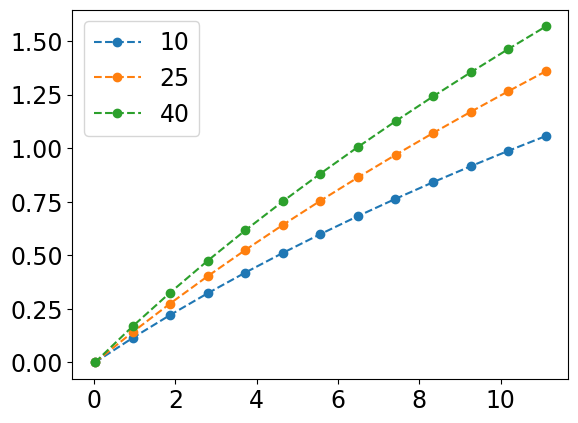

In [ ]:
for i,T_deg in enumerate([10,25,40]):
    plt.plot(
        midc_merge_all[i]['Throughput capacity [kA.h]'], 
        midc_merge_all[i]["CDend LLI lithium plating [%]"],
        '--o', label=str(T_deg))
plt.legend()